配置环境

In [2]:
# 导入必要的库
import torch
import torch.nn as nn
import random
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import *
from tools import *

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(27)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义超参数

In [2]:
# 定义超参数
input_size = 35 # 输入特征的维度
hidden_size = 100 # 隐藏层的维度
num_layers = 2 # BiLSTM 的层数
output_size = 1 # 输出的维度
batch_size = 5 # 批次大小
learning_rate = 0.001 # 学习率
num_epochs = 30 # 训练轮数
seq_len = 30 # 序列长度
train_length = 0.8 # 训练数据长度
step_size = 5 # 学习率变化周期
gamma = 0.5 # 学习率更新值

BiLSTM 模型

In [ ]:
# 定义 BiLSTM 模型
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size) # 乘以2是因为双向的输出要拼接

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 乘以2是因为双向的隐藏层要分开
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # 通过 BiLSTM 层
        out, _ = self.bilstm(x, (h0, c0))
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        # 通过全连接层
        out = self.fc(out)
        return out

# 创建模型实例
model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam 优化器
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

创建 dataset

In [4]:
dataset_1 = create_dataset(1)
dataset_2 = create_dataset(2)
dataset_3 = create_dataset(3)
dataset_4 = create_dataset(4)
dataset_5 = create_dataset(5)
dataset_6 = create_dataset(6)

分离训练集和测试集

In [5]:
# 将数据的前 train_length 的数据作为训练集 train_set
train_size_1 = int(dataset_1.shape[0] * train_length)
train_size_2 = int(dataset_2.shape[0] * train_length)
train_size_3 = int(dataset_3.shape[0] * train_length)
train_size_4 = int(dataset_4.shape[0] * train_length)
train_size_5 = int(dataset_5.shape[0] * train_length)
train_size_6 = int(dataset_6.shape[0] * train_length)
test_size = []
test_size.append(dataset_1.shape[0] * (1 - train_length))
test_size.append(dataset_2.shape[0] * (1 - train_length))
test_size.append(dataset_3.shape[0] * (1 - train_length))
test_size.append(dataset_4.shape[0] * (1 - train_length))
test_size.append(dataset_5.shape[0] * (1 - train_length))
test_size.append(dataset_6.shape[0] * (1 - train_length))

# 分离出训练集和测试集
train_data = []
test_data = []
train_data.append(dataset_1[0:train_size_1])
test_data.append(dataset_1[train_size_1:])
train_data.append(dataset_2[0:train_size_2])
test_data.append(dataset_2[train_size_2:])
train_data.append(dataset_3[0:train_size_3])
test_data.append(dataset_3[train_size_3:])
train_data.append(dataset_4[0:train_size_4])
test_data.append(dataset_4[train_size_4:])
train_data.append(dataset_5[0:train_size_5])
test_data.append(dataset_5[train_size_5:])
train_data.append(dataset_6[0:train_size_6])
test_data.append(dataset_6[train_size_6:])
for i in range(6):
    train_data[i] = create_seq(train_data[i], seq_len)


train = np.concatenate((train_data[0], train_data[1], train_data[2], train_data[3], train_data[4], train_data[5]), axis=0)
np.random.shuffle(train)

训练数据归一化

In [ ]:
scaler, train_scaled = train_scale(train)
dataset = DataPrepare(train_scaled) # 设置 inputs 和 labels
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True)

训练模型

In [ ]:
# 训练模型
min_epochs = 10
best_model = None
min_loss = 1

for epoch in tqdm(range(num_epochs)):
    train_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 1, 35)

        # 梯度清零
        optimizer.zero_grad()
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        
        # 前向传播
        y_pred = model(inputs)
        
        # 计算损失
        loss = loss_function(labels, y_pred)
        train_loss.append(loss.cpu().item())
        
        # 更新梯度
        loss.backward()
        
        # 优化参数
        optimizer.step()
        
    scheduler.step()

    if epoch > min_epochs and loss < min_loss:
            min_val_loss = loss
            best_model = copy.deepcopy(model)

    print('epoch {} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))
    model.train()

    torch.save(model, r'./result/Voltage_model.pth')

测试模型

In [44]:
# 测试模型
test_num = 6 # 测试数据集选择
index = []
with torch.no_grad():
    model = torch.load("./result/Voltage_model.pth")
    print(model)
    
    # 预测测试数据
    print('Forecasting Testing Data')
    predictions_test = list() # 预测值
    expected = list() # 真实值
    inputs_new, labels_new = test_data[test_num-1][0, :5].reshape(1,-1), test_data[test_num-1][0, 5].reshape(1,-1)
    inputs = np.concatenate((inputs_new, train_data[test_num-1][-1, 5:35].reshape(1,-1)), axis=1)
    test = np.concatenate((inputs, labels_new), axis=1)
    scaler, test_scaled = test_scale(test)


    for i in range(int(test_size[test_num-1])):
        # make one-step forecast
        inputs, labels = test_scaled[0, :35], test_scaled[0, 35]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(1, 1, 35)
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        # yhat 为预测值
        yhat = model(inputs)
        
        # 逆归一化
        yhat[0] = invert_scale(scaler, inputs.reshape(35, -1).cpu().numpy(), yhat[0].cpu().detach().numpy())
        labels = labels_new.reshape(-1,)
        predictions_test.append(yhat[0].cpu().detach().numpy()) # 预测值序列
        expected.append(labels) # 真实值序列
        inputs = inputs.reshape(1, 35)
        inputs_new, labels_new = test_data[test_num-1][i, :5].reshape(1,-1), test_data[test_num-1][i, 5].reshape(1,-1)
        inputs = np.concatenate((inputs_new, inputs[0, 6:35].cpu().numpy().reshape(1,-1), yhat.cpu().numpy().reshape(1,-1)), axis=1)
        test = np.concatenate((inputs, labels_new), axis=1)
        scaler, test_scaled = test_scale(test)
        

    # RMSE 评价指标
    rmse_test = sqrt(mean_squared_error(np.array(expected) / 2, np.array(predictions_test) / 2))
    print('Test RMSE: %.3f' % rmse_test)

    # 保存输出结果
    index.append(rmse_test)
    with open(r'./result/voltage_prediction_result_test{}.txt'.format(test_num), 'a', encoding='utf-8') as f:
        for j in range(len(index)):
            f.write(str(index[j]) + " " + str(num_epochs) + " " + str(test_num) + "\n")
    with open(r'./result/voltage_prediction_data_test{}.txt'.format(test_num), 'a', encoding='utf-8') as f:
        f.write('test{}'.format(test_num) + "\n")
        for k in range(len(predictions_test)):
            f.write(str(predictions_test[k].item()) + "\n")

BiLSTM(
  (bilstm): LSTM(35, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)
Forecasting Testing Data
Test RMSE: 0.004


后处理

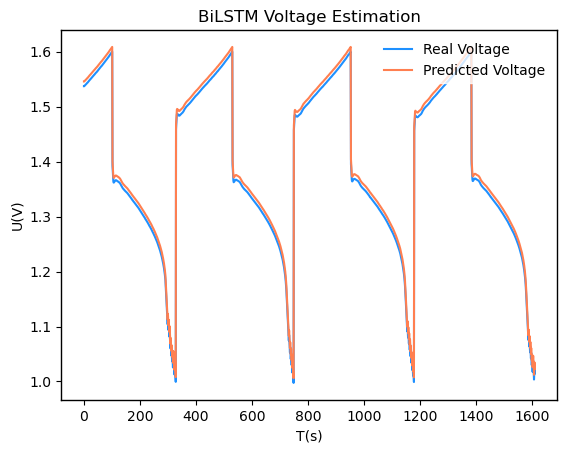

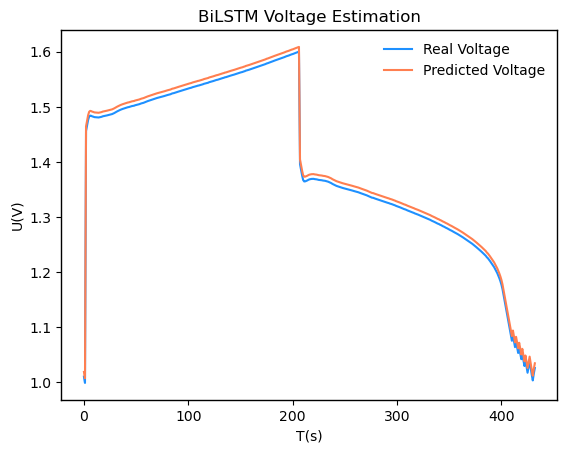

In [45]:
# 绘制 Voltage 预测图像
# 创建横坐标
data_num = len(expected)
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(expected, c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(predictions_test, c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result/Voltage_result_{}.png'.format(test_num))
plt.show()


# 绘制单次充放电循环电压输出预测
# 创建横坐标
start_index = [-612, -612, -532, -530, -555,-434]
end_index = [-1, -1, -1, -1, -1, -1]

data_num = len(expected[start_index[test_num-1]:end_index[test_num-1]])
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(expected[start_index[test_num-1]:end_index[test_num-1]], c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(predictions_test[start_index[test_num-1]:end_index[test_num-1]], c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result/output_voltage_{}.png'.format(test_num))
plt.show()